In [1]:
import pandas as pd
import numpy as np
#import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import DistanceMetric

In [2]:
%matplotlib inline
np.seterr(divide='raise',invalid='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
cd Geolife\ Trajectories\ 1.3

/home/me/Documents/cse523/Geolife Trajectories 1.3


In [4]:
x = pd.read_csv('Data/000/Trajectory/20081103232153.plt', skiprows=6, header=None)

In [5]:
x.head()

,0,1,2,3,4,5,6
0,39.996948,116.325747,0,492,39755.973530,2008-11-03,23:21:53
1,39.996849,116.325763,0,491,39755.973588,2008-11-03,23:21:58
2,39.994409,116.326968,0,23,39755.973646,2008-11-03,23:22:03
3,39.995076,116.326629,0,70,39755.973704,2008-11-03,23:22:08
4,39.995193,116.326572,0,75,39755.973762,2008-11-03,23:22:13


In [6]:
x.shape

(2231, 7)

In [17]:
## distance functions
def point2dist(point, line):
    linelen = np.linalg.norm(line[1]-line[0])
    if linelen==0:
        return 0
    else:
        return np.linalg.norm(np.cross(point-line[0], line[1]-line[0]))/linelen

def vertical_distance(x, y):
    dist_end1 = point2dist(x[0], y)
    dist_end2 = point2dist(x[1], y)
    dist = dist_end1+dist_end2
    if dist == 0:
        return 0
    else:
        return (dist_end1**2 + dist_end2**2)/dist

def parallel_distance(x, y):
    return np.min(np.abs(x[0]-y[0]), np.abs(x[1]-y[1]))

def angular_distance(x, y):
    ylen = np.linalg.norm(y[1]-y[0])
    
    dist = np.dot(x[1]-x[0], y[1]-y[0])
    if dist < 0:
        return np.linalg.norm(x[1]-x[0])
    else:
        return 0 if ylen==0 else np.abs(np.cross(x[1]-x[0], y[1]-y[0]))/ylen
    
def line_distance(x, y):
    return vertical_distance(x, y)+parallel_distance(x, y)+angular_distance(x, y)


In [8]:
# MDL cost
def mdl(data, model_indexes):
    """
    calculate mdl cost
    data the raw data
    model_indexes indexes into the raw data, data points choose by indexes are used to represent the raw data
    """
    # L(H) model cost could have multiple segments
    lh = 0
    for i in range(len(model_indexes)-1):
        dist = np.linalg.norm(data[model_indexes[i]]-data[model_indexes[i+1]])
        lh = lh + np.log2(dist) if dist!=0 else 0
    # L(D|H)
    ldh = 0
    # the index into the model_indexes, NOT into raw data
    model_index = 0
    for i in range(len(data)-1):
        if i > model_indexes[model_index+1]:
            model_index = model_index + 1

        model_i_start = model_indexes[model_index]
        model_i_end = model_indexes[model_index+1]
        
        if i!=model_i_start or i+1!=model_i_end:
            dist = vertical_distance((data[model_i_start], data[model_i_end]),(data[i], data[i+1]))* \
                angular_distance((data[model_i_start], data[model_i_end]), (data[i], data[i+1]))
            ldh = ldh + np.log2(dist) if dist!=0 else 0
    return lh + ldh

In [9]:
## MDL partition algorithm
def mdl_partition(path):
    partition_set = [path[0]]
    start_index = 0
    length = 1
    while start_index + length < len(path):
        curr_index = start_index + length
        # MDL cost if curr_index is included as a characteristic point
        mdlparcost=mdl(path[start_index:curr_index+1], (0, curr_index-start_index))
        # no partition, segmented line
        mdlnoparcost=mdl(path[start_index:curr_index+1], np.arange(curr_index-start_index+1))
        if mdlparcost > mdlnoparcost:
            partition_set = partition_set + [path[curr_index-1]]
            start_index = curr_index-1
            length = 1
        else:
            length = length + 1
    partition_set = partition_set + [path[len(path)-1]]
    return partition_set

In [18]:
partitions=(np.array(mdl_partition(x[[0,1]].values)))

In [21]:
partitions.shape

(877, 2)

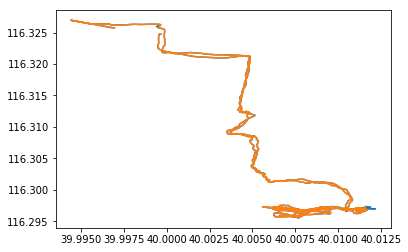

In [19]:
plt.plot(x[0], x[1])

plt.plot(partitions[:, 0], partitions[:, 1])

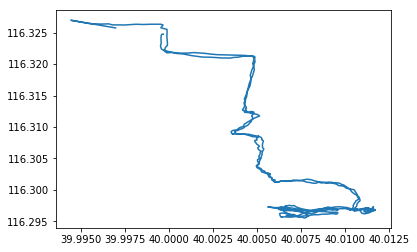

In [20]:
plt.plot(partitions[:, 0], partitions[:, 1])

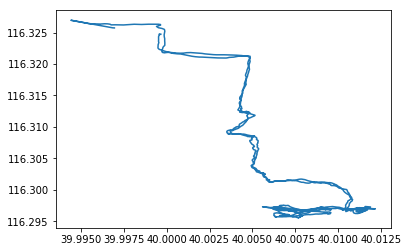

In [20]:
plt.plot(x[0], x[1])

In [23]:
segment_dist=np.zeros(len(partitions)-1)
for i in np.arange(len(partitions)-1):
    segment_dist[i] = np.linalg.norm(partitions[i] - partitions[i+1])

In [25]:
np.histogram(segment_dist)

(array([806,  94,  15,   2,   0,   0,   0,   0,   0,   1]),
 array([  1.41421356e-06,   2.83006035e-04,   5.64597856e-04,
          8.46189677e-04,   1.12778150e-03,   1.40937332e-03,
          1.69096514e-03,   1.97255696e-03,   2.25414878e-03,
          2.53574060e-03,   2.81733243e-03]))

(array([ 208.,  220.,  203.,  124.,   51.,   31.,   18.,   17.,   20.,
           8.,    7.,    3.,    4.,    0.,    1.,    1.,    0.,    0.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([  1.41421356e-06,   5.77325778e-05,   1.14050942e-04,
          1.70369306e-04,   2.26687671e-04,   2.83006035e-04,
          3.39324399e-04,   3.95642763e-04,   4.51961128e-04,
          5.08279492e-04,   5.64597856e-04,   6.20916220e-04,
          6.77234585e-04,   7.33552949e-04,   7.89871313e-04,
          8.46189677e-04,   9.02508042e-04,   9.58826406e-04,
          1.01514477e-03,   1.07146313e-03,   1.12778150e-03,
          1.18409986e-03,   1.24041823e-03,   1.29673659e-03,
          1.35305496e-03,   1.40937332e-03,   1.46569168e-03,
          1.52201005e-03,   1.57832841e-03

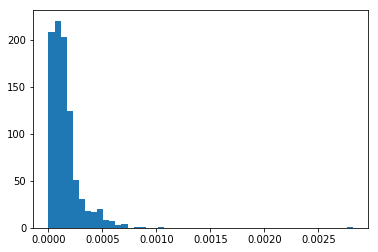

In [29]:
plt.hist(segment_dist, bins=50)

In [ ]:
def segment_clustering(segments, eps, minlines):
    """
    cluster line segment
    segments: line segments to be clustered
    eps: eps-neighbour
    minlines: threshold, mimimum number of lines
    """

In [8]:
segment_type=np.dtype([('x1','f4'),('y1','f4'),('x2','f4'),('y2','f4'),('pathid','i8'),('clusterid','i8')])

In [10]:
xx = np.zeros(100,dtype=segment_type)

In [33]:
def segment_line_dist(x, y):
    return line_distance((np.array([x['x1'],x['y1']]), np.array([x['x2'],x['y2']])),
                         (np.array([y['x1'],y['y1']]), np.array([y['x2'],y['y2']])))

In [32]:
np.array([xx[0]['x1'],xx[0]['y1']])

array([ 0.,  0.], dtype=float32)